In [414]:
%matplotlib inline


Translation with a Sequence to Sequence Network and Attention
*************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__


**Requirements**



In [385]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [386]:
device

device(type='cpu')

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [387]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [388]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [389]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
#     lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
#         read().strip().split('\n')
    lines = open('data/fra-eng/fra.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [390]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [391]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 160872 sentence pairs
Trimmed to 12244 sentence pairs
Counting words...
Counted words:
fra 4785
eng 3116


In [392]:
print(random.choice(pairs))

['elle a de l assurance .', 'she s assertive .']


In [393]:
input_lang.n_words

4785

In [394]:
input_lang.name

'fra'

In [395]:
input_lang.index2word[0]

'SOS'

In [396]:
input_lang.word2index['the']

992

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [397]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [398]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [399]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [400]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [401]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [402]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [403]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [404]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [405]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [406]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [407]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

0m 49s (- 7m 29s) (1000 10%) 2.9800
1m 41s (- 6m 45s) (2000 20%) 2.8544
2m 34s (- 6m 0s) (3000 30%) 2.6945
3m 25s (- 5m 7s) (4000 40%) 2.5739
4m 12s (- 4m 12s) (5000 50%) 2.5496
4m 58s (- 3m 19s) (6000 60%) 2.4590
5m 45s (- 2m 27s) (7000 70%) 2.3941
6m 34s (- 1m 38s) (8000 80%) 2.2910
7m 23s (- 0m 49s) (9000 90%) 2.2498
8m 9s (- 0m 0s) (10000 100%) 2.1630


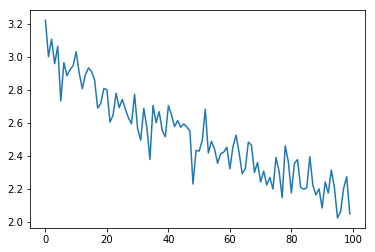

In [417]:
trainIters(encoder1, attn_decoder1, 10000, print_every=1000)

In [418]:
evaluateRandomly(encoder1, attn_decoder1)

> il est en colere apres le monde .
= he s angry at the world .
< he is a good . . <EOS>

> je suis trop fatigue pour penser .
= i m too tired to think .
< i m too old for your . <EOS>

> j en ai marre de garder des secrets .
= i m tired of keeping secrets .
< i m afraid of his . . <EOS>

> je suis nerveux et excite .
= i m nervous and excited .
< i m very with happy . <EOS>

> je suis epuisee .
= i am exhausted .
< i m a . <EOS>

> elle sourit a son bebe .
= she smiled at her baby .
< she saw him in his . <EOS>

> je retourne au bureau .
= i m going back to the office .
< i m going to . . <EOS>

> nous enquetons toujours sur la cause .
= we re still investigating the cause .
< we are all on . . <EOS>

> nous sommes contents que vous soyez la .
= we re glad you re here .
< we re glad you re here . <EOS>

> je ne suis plus marie .
= i m not married anymore .
< i m not allowed . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




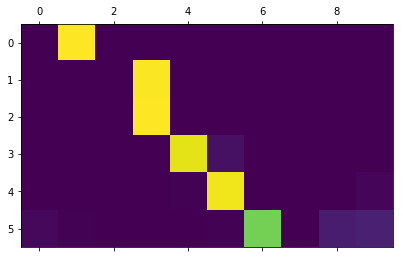

In [419]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = elle a cinq ans de moins que moi .
output = she is him him . <EOS>


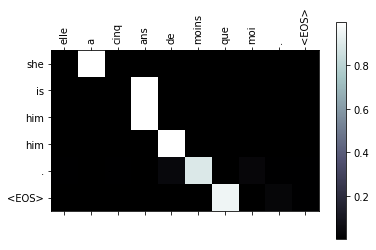

input = elle est trop petit .
output = she is too busy . <EOS>


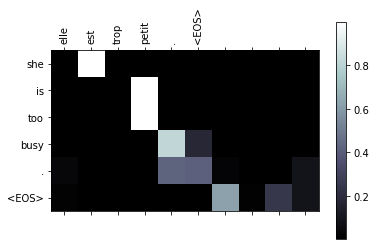

input = je ne crains pas de mourir .
output = i m not afraid . . <EOS>


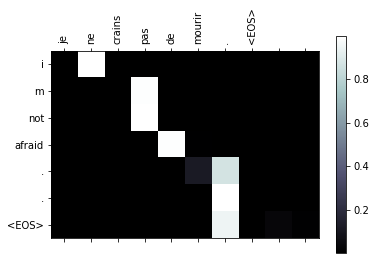

input = c est un jeune directeur plein de talent .
output = he is a bit liar . <EOS>


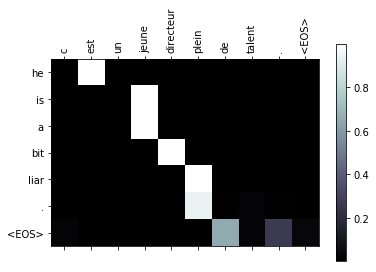

In [420]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# Inspect

```
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
```

In [313]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

In [314]:
input_lang.n_words, output_lang.n_words

(4785, 3116)

```
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
```

In [315]:
len(pairs)

12244

In [316]:
encoder, decoder, n_iters, print_every=encoder1, attn_decoder1, 75000, 5000
learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
random.seed(123)
training_pairs = [tensorsFromPair(random.choice(pairs))
                  for i in range(n_iters)]
criterion = nn.NLLLoss()

In [317]:
[o.shape for o in training_pairs[0]]

[torch.Size([5, 1]), torch.Size([5, 1])]

```
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
 
```

In [318]:
iter = 1
training_pair = training_pairs[iter - 1]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

```
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length
```

In [319]:
iter = 1
training_pair = training_pairs[iter - 1]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion = \
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion
max_length=MAX_LENGTH
max_length

10

```
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
```

## encoder

In [320]:
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

loss = 0

In [321]:
encoder_hidden

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [322]:
encoder_hidden.shape

torch.Size([1, 1, 256])

In [323]:
input_tensor.shape, target_tensor.shape

(torch.Size([5, 1]), torch.Size([5, 1]))

In [324]:
input_length, target_length

(5, 5)

In [325]:
encoder_outputs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [326]:
encoder_outputs.shape

torch.Size([10, 256])

In [327]:
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion = \
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer, criterion
max_length=MAX_LENGTH
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]
    print(ei)
    print(encoder_outputs.shape)

0
torch.Size([10, 256])
1
torch.Size([10, 256])
2
torch.Size([10, 256])
3
torch.Size([10, 256])
4
torch.Size([10, 256])


In [328]:
encoder_outputs.sum(dim=-1), (encoder_outputs.sum(dim=-1)!=0).sum() == input_length

(tensor([-2.9155,  0.6107,  3.9957,  1.6350,  4.4539,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000], grad_fn=<SumBackward1>),
 tensor(1, dtype=torch.uint8))

```
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]
```

In [329]:
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion = \
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer, criterion
max_length=MAX_LENGTH
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

```
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
```

created by
```
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
```

In [330]:
self = encoder1
self.hidden_size, input_lang.n_words, self.embedding, self.gru

(256, 4785, Embedding(4785, 256), GRU(256, 256))

In [331]:

iter = 1
training_pair = training_pairs[iter - 1]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

encoder_hidden = encoder.initHidden()

# for ei in range(input_length):
ei = 0

input, hidden = input_tensor[ei], encoder_hidden
self.embedding(input).shape

torch.Size([1, 256])

In [332]:
embedded = self.embedding(input).view(1, 1, -1) 
embedded.shape

torch.Size([1, 1, 256])

In [333]:
output = embedded
output, hidden = self.gru(output, hidden)

In [334]:
output.shape, hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

https://pytorch.org/docs/stable/nn.html#torch.nn.GRU

Inputs: input, h_0
input of shape (seq_len, batch, input_size): tensor containing the features of the input sequence. The input can also be a packed variable length sequence. See torch.nn.utils.rnn.pack_padded_sequence() for details.
h_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided.
Outputs: output, h_n
output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features h_t from the last layer of the GRU, for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence. For the unpacked case, the directions can be separated using output.view(seq_len, batch, num_directions, hidden_size), with forward and backward being direction 0 and 1 respectively.

Similarly, the directions can be separated in the packed case.

h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len

Like output, the layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size).

In the example above,

Inputs: input, h_0
input of shape (seq_len, batch, input_size)
seq_len, batch, input_size = 1, 1, 256

h_0 of shape (num_layers * num_directions, batch, hidden_size)
num_layers = 1
num_directions = 1
batch, hidden_size = 1, 256

Outputs: output, h_n
output of shape (seq_len, batch, num_directions * hidden_size)
seq_len, batch, num_directions * hidden_size = 1, 1, 1*256

h_n of shape (num_layers * num_directions, batch, hidden_size)
num_layers * num_directions, batch, hidden_size = 1*1, 1, 256

In [335]:
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

loss = 0

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

## decoder

```
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
```

In [336]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_input

tensor([[0]])

In [337]:
decoder_hidden = encoder_hidden
decoder_hidden.shape

torch.Size([1, 1, 256])

In [338]:
target_length

5

In [342]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden

# Teacher forcing: Feed the target as the next input
for di in range(target_length):
    print('di', di)
    print(decoder_input.shape, decoder_hidden.shape, encoder_outputs.shape)
    decoder_output, decoder_hidden, decoder_attention = decoder(
        decoder_input, decoder_hidden, encoder_outputs)
    print(decoder_output.shape, decoder_hidden.shape, decoder_attention.shape)
    loss += criterion(decoder_output, target_tensor[di])
    decoder_input = target_tensor[di]  # Teacher forcing

di 0
torch.Size([1, 1]) torch.Size([1, 1, 256]) torch.Size([10, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256]) torch.Size([1, 10])
di 1
torch.Size([1]) torch.Size([1, 1, 256]) torch.Size([10, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256]) torch.Size([1, 10])
di 2
torch.Size([1]) torch.Size([1, 1, 256]) torch.Size([10, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256]) torch.Size([1, 10])
di 3
torch.Size([1]) torch.Size([1, 1, 256]) torch.Size([10, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256]) torch.Size([1, 10])
di 4
torch.Size([1]) torch.Size([1, 1, 256]) torch.Size([10, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256]) torch.Size([1, 10])


In [341]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden
di = 0
decoder_output, decoder_hidden, decoder_attention = decoder(
        decoder_input, decoder_hidden, encoder_outputs)

decoder_output.shape, decoder_hidden.shape, decoder_attention.shape

(torch.Size([1, 3116]), torch.Size([1, 1, 256]), torch.Size([1, 10]))

```
decoder_output, decoder_hidden, decoder_attention = decoder(
        decoder_input, decoder_hidden, encoder_outputs)
```

```
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
```

```
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
```

In [345]:
self=decoder
self.hidden_size,self.output_size,self.dropout_p,self.max_length,

(256, 3116, 0.1, 10)

In [346]:
self.embedding,self.attn,self.attn_combine,self.dropout,self.gru,self.out,

(Embedding(3116, 256),
 Linear(in_features=512, out_features=10, bias=True),
 Linear(in_features=512, out_features=256, bias=True),
 Dropout(p=0.1),
 GRU(256, 256),
 Linear(in_features=256, out_features=3116, bias=True))

```
def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
```

In [347]:
# setup
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

loss = 0

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden

# in decoder.forward() 
input, hidden, encoder_outputs = decoder_input, decoder_hidden, encoder_outputs
input.shape, hidden.shape, encoder_outputs.shape

(torch.Size([1, 1]), torch.Size([1, 1, 256]), torch.Size([10, 256]))

`embedded = self.embedding(input).view(1, 1, -1)`

In [348]:
self.embedding(input).shape

torch.Size([1, 1, 256])

In [350]:
embedded = self.embedding(input).view(1, 1, -1)
embedded.shape

torch.Size([1, 1, 256])

In [352]:
embedded = self.dropout(embedded)

`attn_weights = F.softmax(
    self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)`

In [356]:
embedded[0].shape, hidden[0].shape, torch.cat((embedded[0], hidden[0]), 1).shape

(torch.Size([1, 256]), torch.Size([1, 256]), torch.Size([1, 512]))

In [357]:
self.attn

Linear(in_features=512, out_features=10, bias=True)

In [358]:
self.attn(torch.cat((embedded[0], hidden[0]), 1)).shape

torch.Size([1, 10])

In [359]:
attn_weights = F.softmax(
    self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
attn_weights.shape

torch.Size([1, 10])

`attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                         encoder_outputs.unsqueeze(0))`

In [363]:
attn_weights.unsqueeze(0).shape, encoder_outputs.unsqueeze(0).shape

(torch.Size([1, 1, 10]), torch.Size([1, 10, 256]))

In [364]:
attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                         encoder_outputs.unsqueeze(0))
attn_applied.shape

torch.Size([1, 1, 256])

`output = torch.cat((embedded[0], attn_applied[0]), 1)`

In [365]:
embedded[0].shape, attn_applied[0].shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [373]:
output = torch.cat((embedded[0], attn_applied[0]), 1)
output.shape

torch.Size([1, 512])

`output = self.attn_combine(output).unsqueeze(0)`

In [374]:
self.attn_combine

Linear(in_features=512, out_features=256, bias=True)

In [375]:
self.attn_combine(output).shape

torch.Size([1, 256])

In [376]:
output = self.attn_combine(output).unsqueeze(0)
output.shape

torch.Size([1, 1, 256])

In [377]:
output = F.relu(output)
output, hidden = self.gru(output, hidden)
output.shape, hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

`output = F.log_softmax(self.out(output[0]), dim=1)`

In [378]:
output[0].shape

torch.Size([1, 256])

In [379]:
self.out

Linear(in_features=256, out_features=3116, bias=True)

In [381]:
self.out(output[0]).shape

torch.Size([1, 3116])

In [382]:
output = F.log_softmax(self.out(output[0]), dim=1)
output.shape

torch.Size([1, 3116])

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




No attention - Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [155]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
# trainIters(encoder1, decoder1, 75000, print_every=5000)

In [156]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [157]:
trainIters(encoder1, decoder1, 1000, print_every=100)

0m 3s (- 0m 34s) (100 10%) 4.1543
0m 8s (- 0m 32s) (200 20%) 3.5679
0m 12s (- 0m 28s) (300 30%) 3.5292
0m 16s (- 0m 25s) (400 40%) 3.6525
0m 21s (- 0m 21s) (500 50%) 3.5490
0m 25s (- 0m 17s) (600 60%) 3.4550
0m 30s (- 0m 12s) (700 70%) 3.3209
0m 34s (- 0m 8s) (800 80%) 3.2924
0m 39s (- 0m 4s) (900 90%) 3.3942
0m 43s (- 0m 0s) (1000 100%) 3.3473


In [159]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
#         decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
#             decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

#         return decoded_words, decoder_attentions[:di + 1]        
        return decoded_words

In [160]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [161]:
evaluateRandomly(encoder1, decoder1)

> vous etes surmene .
= you re overworked .
< you re a . . <EOS>

> tu es plus grande que moi .
= you are taller than me .
< you re a . . <EOS>

> je suis desolee mon pere est elimine .
= i m sorry my father is out .
< you re a . . <EOS>

> je suis une sorte de solitaire .
= i m kind of a loner .
< i m not a . . <EOS>

> elle m a envoye un telegramme urgent .
= she sent me an urgent telegram .
< i m not a . . <EOS>

> emotionnellement je suis vide .
= i m emotionally drained .
< i m not a . . <EOS>

> nous y sommes prets .
= we re ready for this .
< you re a . . <EOS>

> je commence a apercevoir un motif .
= i m beginning to see a pattern .
< i m not a . . <EOS>

> j ai une assuetude .
= i m addicted .
< i m not a . . <EOS>

> je me sens assez malheureux a ce sujet .
= i m quite unhappy about it .
< i m not a . . <EOS>



# No attention - Inspect

```
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, 75000, print_every=5000)
```

In [225]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

In [226]:
input_lang.n_words, output_lang.n_words

(4785, 3116)

```
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
```

In [227]:
len(pairs)

12244

In [228]:
encoder, decoder, n_iters, print_every=encoder1, decoder1, 75000, 5000
learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
random.seed(123)
training_pairs = [tensorsFromPair(random.choice(pairs))
                  for i in range(n_iters)]
criterion = nn.NLLLoss()

In [229]:
[o.shape for o in training_pairs[0]]

[torch.Size([5, 1]), torch.Size([5, 1])]

```
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
 
```

In [230]:
iter = 1
training_pair = training_pairs[iter - 1]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

```
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length
```

In [231]:
iter = 1
training_pair = training_pairs[iter - 1]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion = \
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer, criterion
max_length=MAX_LENGTH
max_length

10

```
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
```

## encoder

In [232]:
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

loss = 0

In [233]:
encoder_hidden

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [234]:
encoder_hidden.shape

torch.Size([1, 1, 256])

In [235]:
input_tensor.shape, target_tensor.shape

(torch.Size([5, 1]), torch.Size([5, 1]))

In [236]:
input_length, target_length

(5, 5)

In [237]:
encoder_outputs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [238]:
encoder_outputs.shape

torch.Size([10, 256])

In [239]:
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion = \
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion
max_length=MAX_LENGTH
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]
    print(ei)
    print(encoder_output.shape, encoder_hidden.shape)

0
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
1
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
2
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
3
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
4
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


In [240]:
encoder_outputs.sum(dim=-1)!=0, (encoder_outputs.sum(dim=-1)!=0).sum() == input_length

(tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.uint8),
 tensor(1, dtype=torch.uint8))

```
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]
```

In [241]:
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion = \
input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer, criterion
max_length=MAX_LENGTH
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

```
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
```

created by
```
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
```

In [242]:
self = encoder1
self.hidden_size, input_lang.n_words, self.embedding, self.gru

(256, 4785, Embedding(4785, 256), GRU(256, 256))

In [243]:

iter = 1
training_pair = training_pairs[iter - 1]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

encoder_hidden = encoder.initHidden()

# for ei in range(input_length):
ei = 0

input, hidden = input_tensor[ei], encoder_hidden
self.embedding(input).shape

torch.Size([1, 256])

In [244]:
embedded = self.embedding(input).view(1, 1, -1) 
embedded.shape

torch.Size([1, 1, 256])

In [245]:
output = embedded
output, hidden = self.gru(output, hidden)

In [246]:
output.shape, hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

https://pytorch.org/docs/stable/nn.html#torch.nn.GRU

Inputs: input, h_0
input of shape (seq_len, batch, input_size): tensor containing the features of the input sequence. The input can also be a packed variable length sequence. See torch.nn.utils.rnn.pack_padded_sequence() for details.
h_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided.
Outputs: output, h_n
output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features h_t from the last layer of the GRU, for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence. For the unpacked case, the directions can be separated using output.view(seq_len, batch, num_directions, hidden_size), with forward and backward being direction 0 and 1 respectively.

Similarly, the directions can be separated in the packed case.

h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len

Like output, the layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size).

In the example above,

Inputs: input, h_0
input of shape (seq_len, batch, input_size)
seq_len, batch, input_size = 1, 1, 256

h_0 of shape (num_layers * num_directions, batch, hidden_size)
num_layers = 1
num_directions = 1
batch, hidden_size = 1, 256

Outputs: output, h_n
output of shape (seq_len, batch, num_directions * hidden_size)
seq_len, batch, num_directions * hidden_size = 1, 1, 1*256

h_n of shape (num_layers * num_directions, batch, hidden_size)
num_layers * num_directions, batch, hidden_size = 1*1, 1, 256

In [247]:
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

loss = 0

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

## decoder

```

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

```

In [248]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_input

tensor([[0]])

In [249]:
decoder_hidden = encoder_hidden
decoder_hidden.shape

torch.Size([1, 1, 256])

In [250]:
target_length

5

In [258]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden

# Teacher forcing: Feed the target as the next input
for di in range(target_length):
    print('di', di)
    print(decoder_input.shape, decoder_hidden.shape)
    decoder_output, decoder_hidden = decoder(
        decoder_input, decoder_hidden)
    print(decoder_output.shape, decoder_hidden.shape)
    loss += criterion(decoder_output, target_tensor[di])
    print(decoder_output.shape, target_tensor[di].shape)
    decoder_input = target_tensor[di]  # Teacher forcing


di 0
torch.Size([1, 1]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1])
di 1
torch.Size([1]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1])
di 2
torch.Size([1]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1])
di 3
torch.Size([1]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1])
di 4
torch.Size([1]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1, 1, 256])
torch.Size([1, 3116]) torch.Size([1])


In [254]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden
di = 0
decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

In [256]:
decoder_output.shape, decoder_hidden.shape

(torch.Size([1, 3116]), torch.Size([1, 1, 256]))

```
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
```

```
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
```

In [259]:
self=decoder
self.hidden_size, self.embedding, self.gru, self.out, self.softmax

(256,
 Embedding(3116, 256),
 GRU(256, 256),
 Linear(in_features=256, out_features=3116, bias=True),
 LogSoftmax())

```
def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
```

In [266]:
encoder_hidden = encoder.initHidden()

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

loss = 0

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]
    
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden
input, hidden = decoder_input, decoder_hidden
output = self.embedding(input).view(1, 1, -1)

In [267]:
self.embedding(input).shape, output.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [268]:
output = F.relu(output)
output, hidden = self.gru(output, hidden)
output.shape, hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [269]:
self.out(output[0]).shape

torch.Size([1, 3116])

In [263]:
output = self.softmax(self.out(output[0]))
output.shape

torch.Size([1, 3116])